In [21]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date, datetime, timedelta
import pickle
import plotly.offline as py
import plotly.graph_objs as go
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import cufflinks as cf
import seaborn as sns

In [22]:
turbine_readings = pickle.load(open("./data/turbine_readings.pickle","rb")) 
weather_data = pd.read_csv("hourly_weather_data.csv")

Preprocessing both turbine data and weather data.

In [23]:
weather_data = weather_data.dropna(axis=1, how="all")
weather_data.fillna(method="ffill", inplace=True)
weather_data["timestamp"] = pd.to_datetime(weather_data["valid_time_gmt"], unit="s") - pd.Timedelta("08:00:00")
weather_data["weather_date"] = weather_data["timestamp"].dt.date
weather_data["weather_time"] = weather_data["timestamp"].dt.time
weather_data["weather_month"] = weather_data["timestamp"].dt.month
weather_data["weather_day_of_month"] = weather_data["timestamp"].dt.day
weather_data["weather_day_of_week"] = weather_data["timestamp"].dt.dayofweek

turbine_readings["turbine_date"] = turbine_readings["timestamp"].dt.date
turbine_readings["turbine_time"] = turbine_readings["timestamp"].dt.time
turbine_readings["turbine_month"] = turbine_readings["timestamp"].dt.month
turbine_readings["turbine_day_of_month"] = turbine_readings["timestamp"].dt.day
turbine_readings["turbine_day_of_week"] = turbine_readings["timestamp"].dt.dayofweek

turbine_names = [col for col in turbine_readings if col.startswith("kW")]

count = 1
for index, row in turbine_readings.iterrows():
    if count == 101:
        count = 1
    turbine_readings.loc[index, "reading_in_week"] = count
    count += 1
    turbine = turbine_readings.loc[index, turbine_names]
    turbine_readings.loc[index, "median_kW_reading"] = turbine.median()
    turbine_readings.loc[index, "avg_kW_reading"] = turbine.mean()

feature_dict = {"wspd" : "Windspeed (mph)",
                "wdir" : "Wind Direction (azimuth)",
                "temp" : "Temperature (Fahrenheit)",
                "feels_like" : "Feels Like Temperature (Fahrenheit)"}

In [24]:
for feature in feature_dict:
    trace1 = go.Scatter(
        x=turbine_readings["timestamp"],
        y=turbine_readings["avg_kW_reading"],
        mode="lines",
        name="Average Turbine Reading"
    )

    trace2 = go.Scatter(
        x=weather_data["timestamp"],
        y=weather_data[feature],
        mode="lines",
        name=feature_dict[feature],
        yaxis="y2"
    )

    data = [trace1, trace2]
    layout = go.Layout(
        title='Turbine Output vs. ' + feature_dict[feature],
        yaxis=dict(
            title='Turbine Output (kWh)',
            titlefont=dict(
                color='#1f77b4'
            ),
            tickfont=dict(
                color='#1f77b4'
            )
        ),
        yaxis2=dict(
            title=feature_dict[feature],
            titlefont=dict(
                color='#ff7f0e'
            ),
            tickfont=dict(
                color='#ff7f0e'
            ),
            overlaying='y',
            side='right'
        )
    )

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [25]:
turbine_weather_df = pd.merge_asof(left=turbine_readings, right=weather_data, on="timestamp", direction="nearest")
turbine_weather_df.to_csv("./data/turbine&weather_combined.csv", index=False)
pickle_out = open("./data/turbine&weather_combined.pickle", "wb")
pickle.dump(turbine_weather_df, pickle_out)
pickle_out.close()

In [26]:
for feature in feature_dict:
    trace = go.Scatter(x=turbine_weather_df[feature],
                       y=turbine_weather_df["avg_kW_reading"],
                       mode='markers',
                       opacity=.9)
    data=[trace]

    layout = go.Layout(
        title='Turbine Output vs. ' + feature_dict[feature],
        yaxis=dict(
            title='Turbine Output (kWh)'
        ),
        xaxis=dict(
            title=feature_dict[feature]
        )
    )

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

Text(0.5,1,'Average Wind Speed by Time of Day')

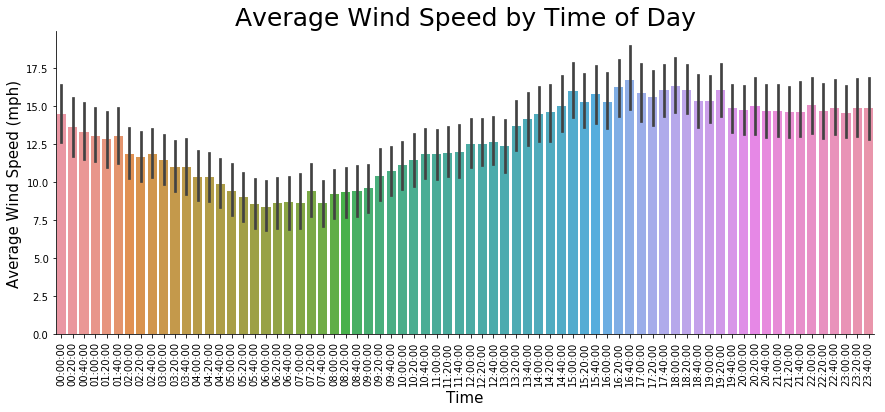

In [27]:
fig = sns.catplot(x="weather_time" ,y="wspd", data=weather_data, kind='bar', aspect=2.5, ci=95, n_boot=1000)
fig.set_xticklabels(rotation=90)
fig.set_xlabels("Time", fontsize=15)
fig.set_ylabels("Average Wind Speed (mph)", fontsize=15)
plt.title("Average Wind Speed by Time of Day", fontsize=25)

Text(0.5,1,'Turbine Readings w/o Timestamps')

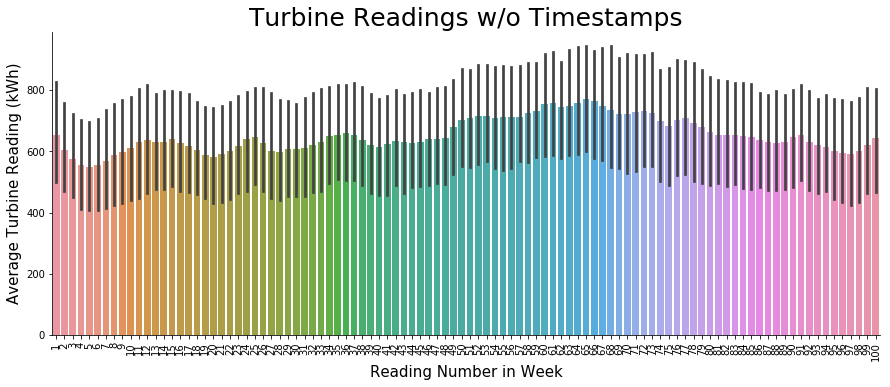

In [28]:
fig = sns.catplot(x="reading_in_week" ,y="avg_kW_reading", data=turbine_readings, kind='bar', aspect=2.5, ci=95, n_boot=1000)
fig.set_xticklabels(range(1, 101), rotation=90)
fig.set_xlabels("Reading Number in Week", fontsize=15)
fig.set_ylabels("Average Turbine Reading (kWh)", fontsize=15)
plt.title("Turbine Readings w/o Timestamps", fontsize=25)

Text(0.5,1,'Turbine Reading by Time of Day')

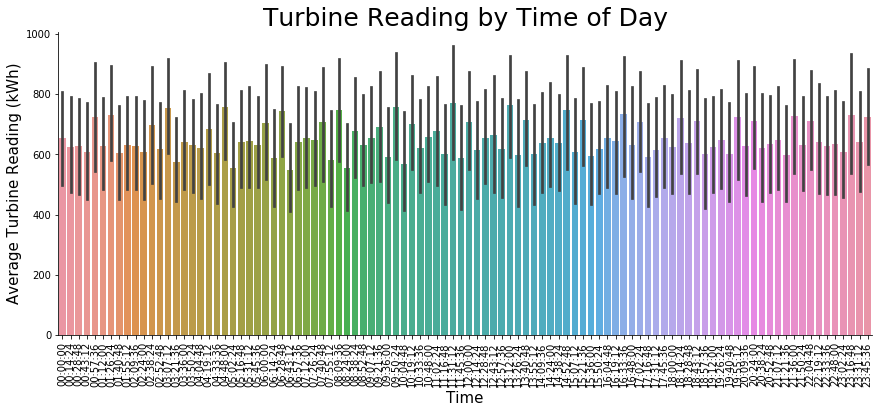

In [29]:
turbine_readings = turbine_readings.sort_values(by=["turbine_time"])
fig = sns.catplot(x="turbine_time" ,y="avg_kW_reading", data=turbine_readings, kind='bar', aspect=2.5, ci=95, n_boot=1000)
fig.set_xticklabels(rotation=90)
fig.set_xlabels("Time", fontsize=15)
fig.set_ylabels("Average Turbine Reading (kWh)", fontsize=15)
plt.title("Turbine Reading by Time of Day", fontsize=25)

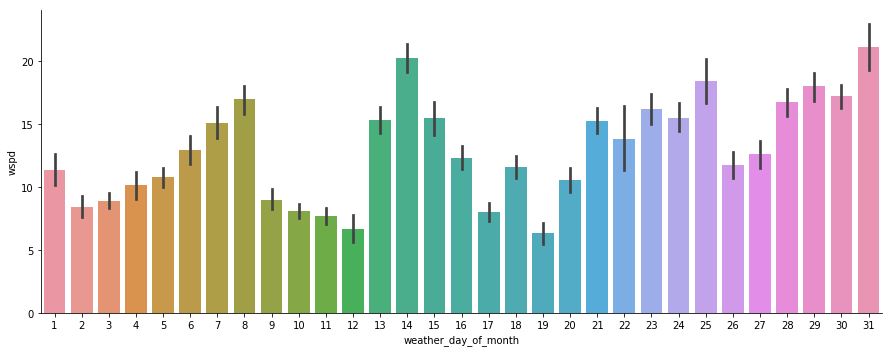

In [30]:
fig = sns.catplot(x="weather_day_of_month" ,y="wspd", data=weather_data, kind='bar', aspect=2.5, ci=95, n_boot=1000)

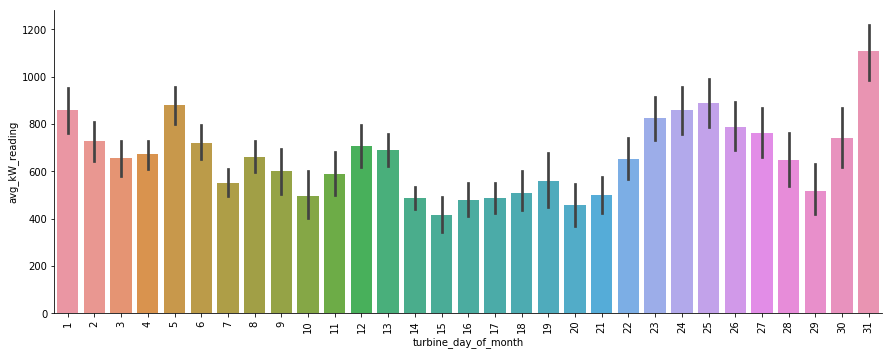

In [31]:
fig = sns.catplot(x="turbine_day_of_month" ,y="avg_kW_reading", data=turbine_readings, kind='bar', aspect=2.5, ci=95, n_boot=1000)
fig.set_xticklabels(rotation=90)

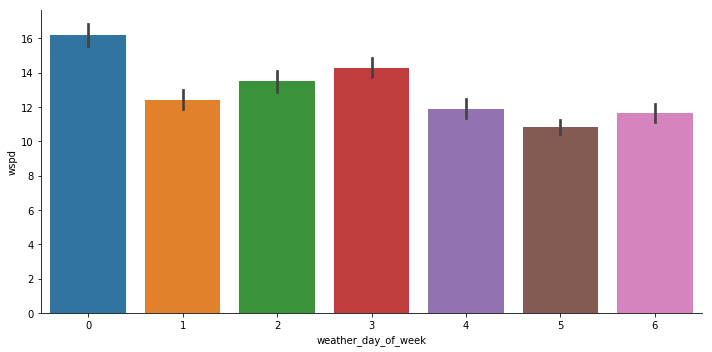

In [32]:
fig = sns.catplot(x="weather_day_of_week" ,y="wspd", data=weather_data, kind='bar', aspect=2, ci=95, n_boot=1000)

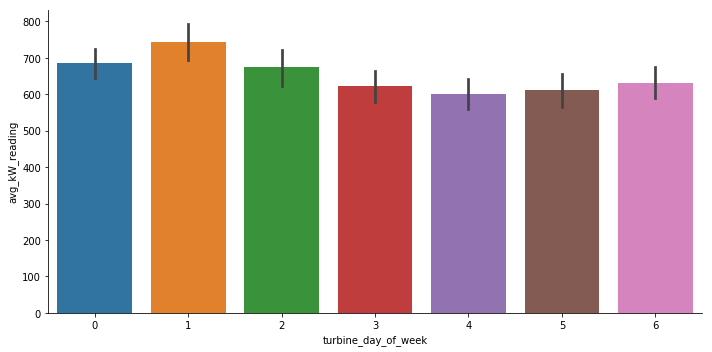

In [33]:
fig = sns.catplot(x="turbine_day_of_week" ,y="avg_kW_reading", data=turbine_readings, kind='bar', aspect=2, ci=95, n_boot=1000)

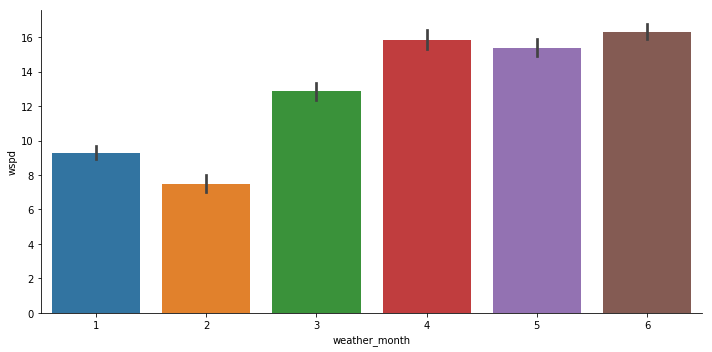

In [34]:
fig = sns.catplot(x="weather_month" ,y="wspd", data=weather_data, kind='bar', aspect=2, ci=95, n_boot=1000)

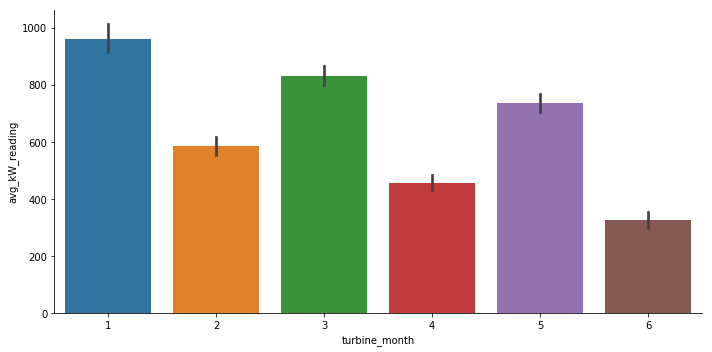

In [35]:
fig = sns.catplot(x="turbine_month" ,y="avg_kW_reading", data=turbine_readings, kind='bar', aspect=2, ci=95, n_boot=1000)

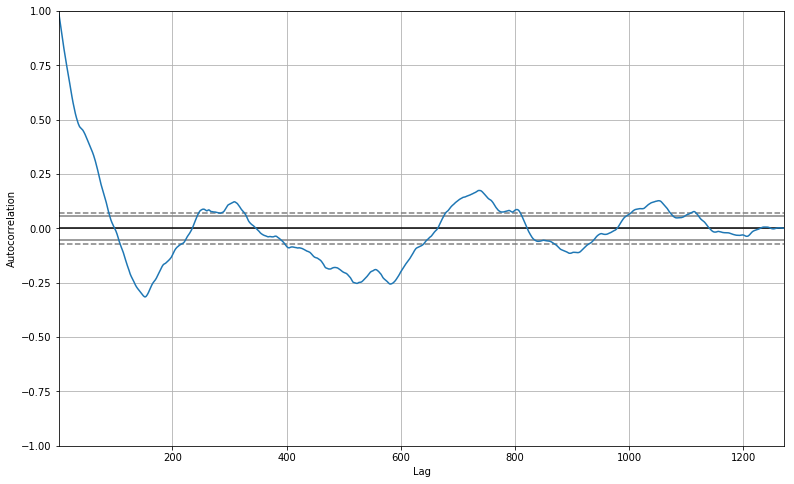

In [36]:
turbine_readings = turbine_readings.sort_index()
turbine_readings_subset = turbine_readings.loc[turbine_readings["timestamp"] <= datetime(2016, 3, 30)]

from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(13,8))
autocorrelation_plot(turbine_readings_subset["avg_kW_reading"])

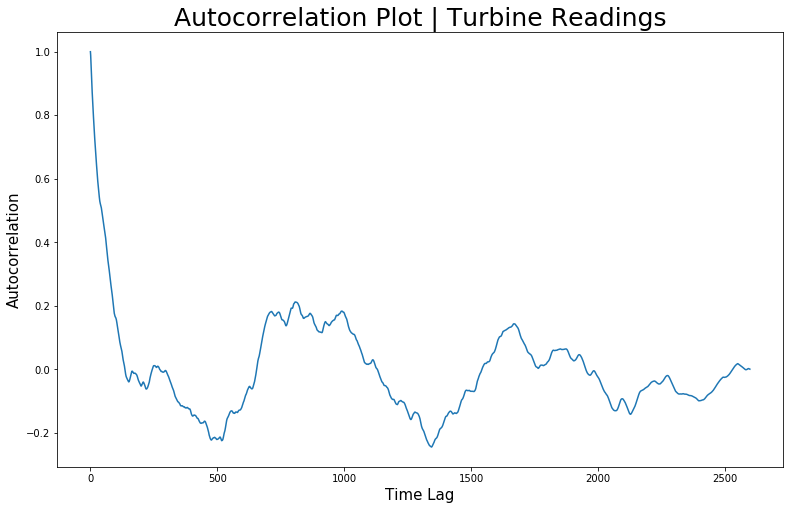

In [37]:
from statsmodels.tsa.stattools import acf
autocorrelation = acf(turbine_readings["avg_kW_reading"], nlags=3000)
plt.figure(figsize=(13,8))
plt.title("Autocorrelation Plot | Turbine Readings", fontsize=25)
plt.xlabel("Time Lag", fontsize=15)
plt.ylabel("Autocorrelation", fontsize=15)
plt.plot(autocorrelation)

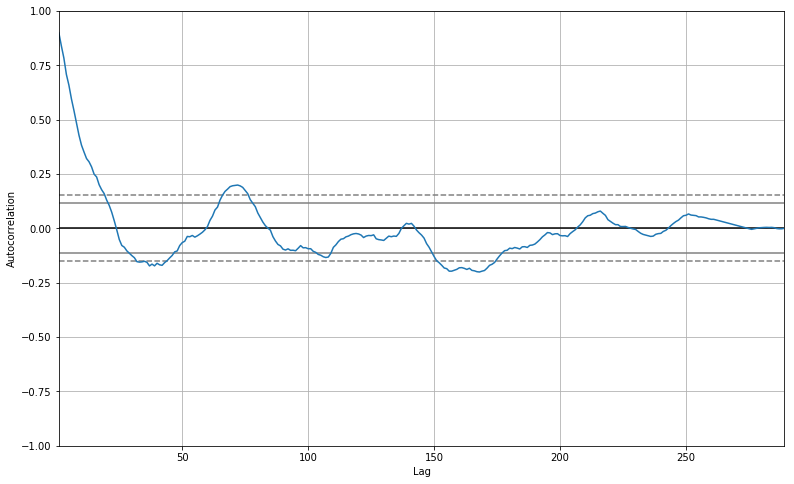

In [38]:
weather_data_subset = weather_data.loc[weather_data["timestamp"] <= datetime(2016, 1, 5)]
weather_data_subset = weather_data_subset.dropna(subset=["wspd"])
feature = "wspd"
plt.figure(figsize=(13,8))
autocorrelation_plot(weather_data_subset[feature])

           0
60  0.007930
61  0.036502
62  0.055960
63  0.084520
64  0.097758
65  0.129968
66  0.152730
67  0.170061
68  0.180479
69  0.191921
70  0.195901
71  0.197783
72  0.199186
73  0.195394
74  0.188475
75  0.173748
76  0.159727
77  0.132135
78  0.115541
79  0.099946
            0
130 -0.055574
131 -0.045552
132 -0.035659
133 -0.038427
134 -0.035331
135 -0.036843
136 -0.023493
137 -0.000327
138  0.011958
139  0.023090
140  0.019501
141  0.022824
142  0.010145
143 -0.007527
144 -0.020078
145 -0.030709
146 -0.044796
147 -0.070021
148 -0.086925
149 -0.108438
(289,)


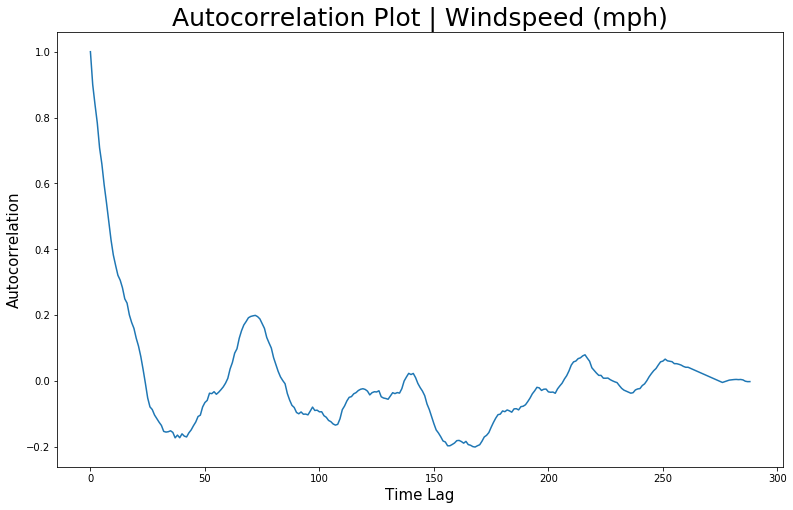

In [39]:
autocorrelation = acf(weather_data_subset[feature], nlags=5000)
df = pd.DataFrame(autocorrelation)
print(df.iloc[60:80,:])
print(df.iloc[130:150,:])
print(weather_data_subset["wspd"].shape)
plt.figure(figsize=(13,8))
plt.title("Autocorrelation Plot | " + feature_dict[feature], fontsize=25)
plt.xlabel("Time Lag", fontsize=15)
plt.ylabel("Autocorrelation", fontsize=15)
plt.plot(autocorrelation)

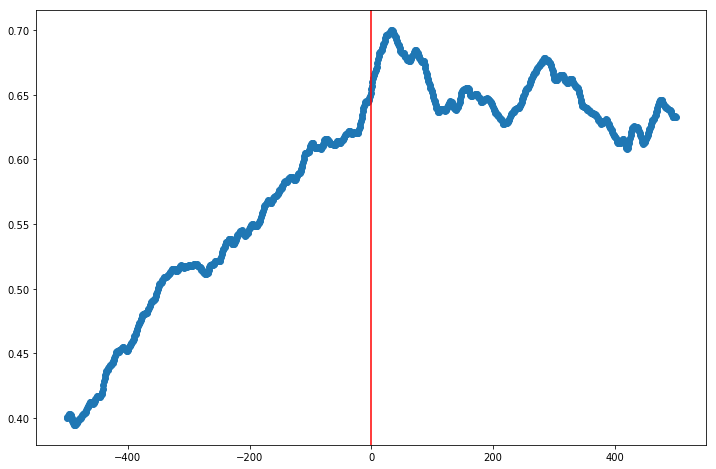

In [40]:
plt.figure(figsize=(12, 8))
plt.xcorr(turbine_weather_df["wspd"], turbine_weather_df["avg_kW_reading"], maxlags=500, normed=True, usevlines=False)
plt.axvline(x=0, color="red")